In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import re
import warnings
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
warnings.simplefilter(action='ignore', category=FutureWarning)
import tensorflow as tf
warnings.resetwarnings()

ModuleNotFoundError: No module named 'keras'

Using https://www.tensorflow.org/tutorials/structured_data/time_series
as a reference

In [8]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [9]:
# Load data that has user generated features (rolling averages)

df = pd.read_csv('model_data.csv', index_col=0)

In [10]:
def country_groupby_indices_list(df):
    return [df[df.location==country].index for country in df.location.unique()]

In [11]:
window_size = 14
forecast_interval = 14

### The train test split is performed in the following manner.

Training target ranges from time-indices 14 (not zero to provide a bare minimum of data) to 86,
with the targets they are predicting running from  28 to 100. For the validation data, the predictors
come from index 101, and they are used to predict 102-115. 


Originally, I made sure to not use the predictor (X) data indexed from 87-100 to validate, to absolutely ensure there
is no overlap between validation and training. I.e. the training targets include the new_cases_per_million 
from 87-100 and I am unsure if reusing this data as predictors would cause overlap. I'm not sure if this was right
so I've changed it to use 87-100 to validate, using future values 

In [12]:
def multi_step_split(df, start_index, end_index, history_size, forecast_interval):
    data = []
    labels = []
    
    # minimum start is window size
    start_index = start_index + history_size
    df_model = df.drop(columns=['location','date'])
    for country_indices in cgi:
        country_df = df_model.loc[country_indices, :].reset_index(drop=True)
        if end_index is None:
            # has to end before the values it wants to predict
            end_index = len(country_df) - forecast_interval
        for i in range(start_index, end_index+1):
            data.append(country_df.iloc[i-window_size:i, :].values)
            labels.append(country_df.new_cases_per_million.iloc[i:i+forecast_interval].values)
    return np.array(data), np.array(labels)

In [24]:
history_size = 14
forecast_interval = 14
# only validate on one week of data, (i.e. the two week forecasts of the second to last week).
# 
# 2 weeks of history, 2 weeks of train
TRAIN_SPLIT = df.date_proxy.nunique() - 14

training on largest possible window of data -> single predictive day -> T - 14 | T | T + 14

df.iloc[-14:, :] -> unused predictors, y used for t=T prediction. 
df.iloc[-15, :] -> validation set.
df.iloc[:-15-14,:] -> train, with predictions up until "present day", (T-14 treated as present day) up to and including 87.

train on all windows of length 14, 15, ...... etc. 
simply make a padded 
prediction day is 101, interval is 102-115
but need 14 day training buffer so the window size is from 0 to 87 -> 88 value

In [14]:
y = df.loc[:, ['date_proxy', 'new_cases_per_million']]

In [15]:
# date_proxy value for last day in training set
TRAIN_SPLIT = 86

df_model = df.iloc[:, :-2]#drop(columns=['location', 'date'])
df_mean = df_model[df.date_proxy<=TRAIN_SPLIT].mean(axis=0)
df_std = df_model[df.date_proxy<=TRAIN_SPLIT].std(axis=0)

# going to drop date proxy before creating batches.
df_model.iloc[:, 1:] = (df_model.iloc[:, 1:] - df_mean.iloc[1:]) / df_std.iloc[1:]


so, loop through the countries, loop through the date range (14, 87) and produce (86-14) windows of length 87, with padding.

In [155]:
df_model[(df_model.date_proxy > i) & (df_model.date_proxy <= i + forecast_interval)].date_proxy.nunique()

14

In [46]:
x_train, y_train = [], []
x_validate, y_validate = [], []
maxlen = 14
start_index = 14
end_index = 87
for country_indices in country_groupby_indices_list(df):
    country_df = df_model.loc[country_indices, :].reset_index(drop=True)
    country_y = y.loc[country_indices,:].reset_index(drop=True)
    for i in range(start_index, end_index): 
        # unpadded window
        sequence = country_df[country_df.date_proxy <= i].values
        # because the padding function always pads the number of columns, need to flip things twice 
        padded_window = pad_sequences(sequence.transpose(), maxlen=maxlen).transpose()
        x_train.append(padded_window)
        y_train.append(country_y[(country_y.date_proxy > i) 
                                  & (country_y.date_proxy <= i + forecast_interval)].new_cases_per_million.values)
    
    for ival in range(end_index, end_index + forecast_interval):
        val_sequence = country_df[country_df.date_proxy <= ival].values
        # because the padding function always pads the number of columns, need to flip things twice 
        val_padded_window = pad_sequences(val_sequence.transpose(), maxlen=maxlen).transpose()
        x_validate.append(val_padded_window)
        y_validate.append(country_y[(country_y.date_proxy > ival) 
                                     & (country_y.date_proxy <= ival + forecast_interval)].new_cases_per_million.values)
          
#     val_sequence = country_df[country_df.date_proxy <= end_index + 14].drop(columns='date_proxy').values
#     # because the padding function always pads the number of columns, need to flip things twice 
#     val_padded_window = pad_sequences(val_sequence.transpose(), maxlen=maxlen).transpose()
#     x_validate.append(val_padded_window)
#     y_validate.append(country_df[country_df.date_proxy > end_index + 14].new_cases_per_million.values)
x_train, y_train = np.array(x_train), np.array(y_train)
x_validate, y_validate = np.array(x_validate), np.array(y_validate)

In [47]:
9198 / df.location.nunique()

73.0

In [48]:
87 - 14

73

In [49]:
x_train.shape, y_train.shape

((9198, 14, 248), (9198, 14))

In [50]:
x_validate.shape, y_validate.shape

((1764, 14, 248), (1764, 14))

Keras expects data of dim (batch, time, features), so first
put all data in (time, features) format then choose windows? 

In [52]:
1764 / df.location.nunique()

14.0

In [30]:
# Number of samples in train
N_s = x_train.shape[0]
# Number of input nodes
N_i = 87
# Number of output nodes
N_o = 14
alpha = 5

N_h = (N_s / (alpha * (N_i + N_o)))
print(N_h)

18.213861386138614


In [33]:
model = tf.keras.models.Sequential()
# this would take all dates and ravel into a single vector 
model.add(tf.keras.layers.LSTM(16,  return_sequences=True, input_shape=(history_size, x_train.shape[-1])))
# maybe the following is possible / worthwhile?
model.add(tf.keras.layers.LSTM(16,  return_sequences=False, input_shape=(history_size, x_train.shape[-1])))
# model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(14))

# activation that is strictly positive is desirable I believe, so softmax, ReLU? just not tanh I believe. 
# model.add(Activation('relu'))
# metrics only prints stuff at end of each epoch. 
model.compile(loss='mae', optimizer='adam')#, metrics=['acc'])
model.fit(x_train, y_train, epochs=10, validation_data=(x_validate, y_validate), batches=256)

Train on 9198 samples, validate on 1890 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
9198/9198 [==============================] - 5s 595us/sample - loss: 8.0530 - val_loss: 13.7303
Epoch 2/10
9198/9198 [==============================] - 4s 461us/sample - loss: 7.1617 - val_loss: 12.8254
Epoch 3/10
9198/9198 [==============================] - 4s 460us/sample - loss: 6.6785 - val_loss: 12.2805
Epoch 4/10
9198/9198 [==============================] - 4s 462us/sample - loss: 6.3323 - val_loss: 11.8274
Epoch 5/10
9198/9198 [==============================] - 4s 458us/sample - loss: 5.9966 - val_loss: 11.0993
Epoch 6/10
9198/9198 [==============================] - 4s 458us/sample - loss: 5.7183 - val_loss: 10.7803
Epoch 7/10
9198/9198 [==============================] - 4s 461us/sample - loss: 5.4717 - val_loss: 10.4481
Epoch 8/10
9198/9198 [==============================] - 4s 460us/sample - loss: 5.2447 - val_loss: 10.2250
Ep

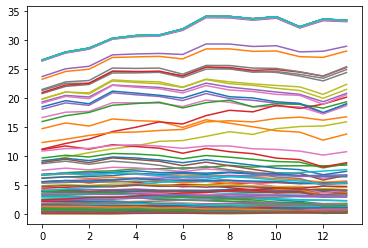

In [38]:
_ = plt.plot(y_predict.transpose())

Explicit goal: predict the 14 day future of any given window of time series data. 

easy : make all windows an identical length of time. 

harder : make all windows vary in lengths between different batches. 
https://datascience.stackexchange.com/questions/26366/training-an-rnn-with-examples-of-different-lengths-in-keras

Now the key difficulty I think is how the data is to be rearranged. https://www.tensorflow.org/tutorials/structured_data/time_series indicates that I need a tensor with three dimensions,
axis = 0 is "batch size" axis = 1 is "time steps" and axis = 2 is "features". 

In this case, the window size should incorporate all possible data into the training set, i.e. a cumulative window
as opposed to a rolling window.

Batch size in this case just means size of training or testing set. therefore, the window should equal batch size?

i.e. shape of data is (window, window, 1). This only trains on a single window instead of stepping through with a smaller window. should likely test which is better.


The main issue is making sure the training and validation data are ordered correctly. let's look at the cumulative
history data from all countries? I have to specify the input shape so this isn't possible....

I.e. the tutorial uses many different windows of small finite size compared to number of samples to predict the future. Do I have enough data for this? 

This key seems to be to slice the data in a time-preserving manner prior to any calculations. i.e. whenever a 

A batch size is going to be the number of ***windows*** taken from the data set, 

cache : Caches the elements in this dataset.

The first time the dataset is iterated over, its elements will be cached either in the specified file or in memory. Subsequent iterations will use the cached data.

batch : Combines consecutive elements of this dataset into batches.  is a collection of windows that come from the BUFFER produced by SHUFFLE

Combines consecutive elements of this dataset into batches.

The components of the resulting element will have an additional outer dimension, which will be batch_size (or N % batch_size for the last element if batch_size does not divide the number of input elements N evenly and drop_remainder is False). If your program depends on the batches having the same outer dimension, you should set the drop_remainder argument to True to prevent the smaller batch from being produced.


shuffle : 

Randomly shuffles the elements of this dataset.

This dataset fills a buffer with buffer_size elements, then randomly samples elements from this buffer, replacing the selected elements with new elements. For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required.

For instance, if your dataset contains 10,000 elements but buffer_size is set to 1,000, then shuffle will initially select a random element from only the first 1,000 elements in the buffer. Once an element is selected, its space in the buffer is replaced by the next (i.e. 1,001-st) element, maintaining the 1,000 element buffer.



buffer_size : A tf.int64 scalar tf.Tensor, representing the number of elements from this dataset from which the new dataset will sample.

repeat : Repeats this dataset so each original value is seen count times.